In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

In [2]:
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Data preprocessing and normalization
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


In [ ]:
# Generator
def build_generator(latent_dim):
    generator = Sequential([
        Dense(4 * 4 * 256, input_dim=latent_dim),
        Reshape((4, 4, 256)),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'),
        Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh')  # Use tanh activation for better performance in DCGAN
    ])
    return generator

from tensorflow.keras.layers import Input, Concatenate

# Discriminator
def build_discriminator(num_classes):
    img_input = Input(shape=(32, 32, 3))
    
    # Convolutional layers
    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', activation='relu')(img_input)
    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = Flatten()(x)
    
    # Common dense layer
    x = Dense(128, activation='relu')(x)
    
    # Output layer for real/fake classification
    validity = Dense(1, activation='sigmoid')(x)
    
    # Output layer for class prediction
    label = Dense(num_classes, activation='softmax')(x)
    
    # Combine the outputs
    discriminator = Model(img_input, [validity, label])
    
    return discriminator

from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

# Custom loss functions for discriminator
def discriminator_loss(real_labels, fake_labels):
    # Binary cross-entropy loss for real and fake images
    real_loss = binary_crossentropy(tf.ones_like(real_labels), real_labels)
    fake_loss = binary_crossentropy(tf.zeros_like(fake_labels), fake_labels)
    # Total discriminator loss
    total_loss = real_loss + fake_loss
    return total_loss


def discriminator_class_loss(real_output, fake_output, real_labels):
    real_loss = CategoricalCrossentropy()(real_labels, real_output)
    fake_loss = CategoricalCrossentropy()(real_labels, fake_output)
    return real_loss + fake_loss



In [ ]:
from tensorflow.keras.models import Model
from keras.losses import binary_crossentropy

# Define GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator's weights during GAN training
    gan = Sequential([generator, discriminator])
    return gan

# Parameters
latent_dim = 100
num_classes = 11  # CIFAR-10 classes (10) + Fake class (1)
epochs = 5
batch_size = 128

# Initialize generator, discriminator, and GAN
generator = build_generator(latent_dim)
discriminator = build_discriminator(num_classes)
gan = build_gan(generator, discriminator)

# Compile models
# Compile models
generator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001, beta_1=0.5))
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# Compile discriminator
discriminator.compile(loss=discriminator_loss, optimizer=Adam(learning_rate=0.001, beta_1=0.5))


# Print model summaries
generator.summary()
discriminator.summary()
gan.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 3)      │         6,147 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,531 (4.60 MB)

 Trainable params: 1,206,531 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      3,136 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 128) │    131,200 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  1,048,704 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 11)        │      1,419 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,184,588 (4.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,184,588 (4.52 MB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │     1,206,531 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ ?                      │     1,184,588 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,391,119 (9.12 MB)

 Trainable params: 1,206,531 (4.60 MB)

 Non-trainable params: 1,184,588 (4.52 MB)

In [ ]:
# Training loop
def train_gan(generator, discriminator, gan, x_train, epochs, batch_size):
    num_batches = x_train.shape[0] // batch_size
    half_batch = batch_size // 2
    d_loss_hist, g_loss_hist = [], []
    for epoch in range(epochs):
        d_loss_total, g_loss_total = 0.0, 0.0
        for batch_idx in range(num_batches):
            # Train discriminator
            idx = np.random.randint(0, x_train.shape[0], half_batch)
            real_images = x_train[idx]
            noise = np.random.normal(0, 1, (half_batch, latent_dim))
            fake_images = generator.predict(noise)
            real_labels = np.ones((half_batch, 1))
            fake_labels = np.zeros((half_batch, 1))
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            valid_labels = np.ones((batch_size, 1))
            g_loss = gan.train_on_batch(noise, valid_labels)

            d_loss_total += d_loss
            g_loss_total += g_loss

        d_loss_avg = d_loss_total / num_batches
        g_loss_avg = g_loss_total / num_batches
        d_loss_hist.append(d_loss_avg)
        g_loss_hist.append(g_loss_avg)
        print(f"Epoch {epoch+1}/{epochs} -- Discriminator Loss: {d_loss_avg}, Generator Loss: {g_loss_avg}")
    
    return d_loss_hist, g_loss_hist

In [ ]:
# Train GAN
d_loss_hist, g_loss_hist = train_gan(generator, discriminator, gan, x_train, epochs, batch_size)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  


I0000 00:00:1712764105.915006   74120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


W0000 00:00:1712764110.307277   74120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764110.310453   74120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

In [ ]:
# Visualizing generated images
def plot_generated_images(generator, epoch, test_input, real_images):
    predictions = generator(test_input, training=False)
    fig = plt.figure(figsize=(10, 10))
    for i in range(5):
        plt.subplot(5, 5, i+1)
        plt.imshow((predictions[i].numpy() * 255).astype('int'))
        plt.axis('off')
    plt.suptitle('Generated Images', fontsize=16)
    plt.savefig(f'generated_images_epoch_{epoch}.png')
    plt.show()

# Selecting random real images
def select_real_images(x_test, num_images=5):
    indices = np.random.choice(len(x_test), num_images, replace=False)
    return x_test[indices]

# Plotting real images
def plot_real_images(real_images):
    fig = plt.figure(figsize=(10, 10))
    for i in range(real_images.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow((real_images[i] * 255).astype('int'))
        plt.axis('off')
    plt.suptitle('Real Images', fontsize=16)
    plt.show()


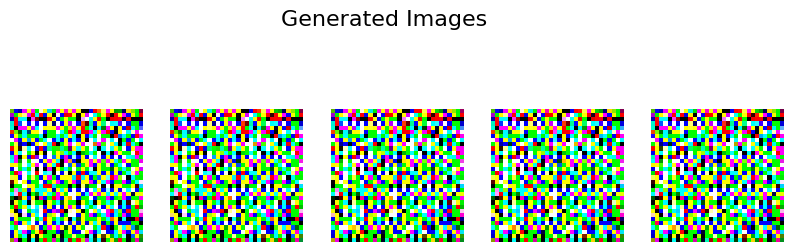

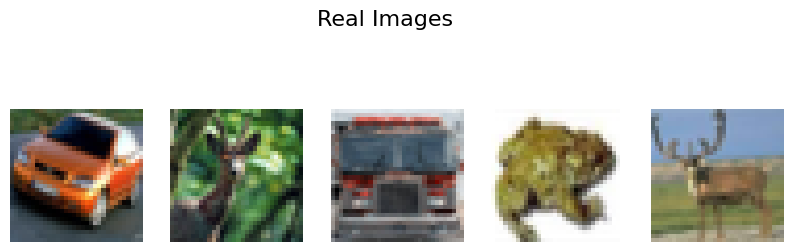

In [ ]:
# Generate and plot images
test_noise = np.random.normal(0, 1, (25, latent_dim))
real_images = select_real_images(x_test)
plot_generated_images(generator, epochs, test_noise, real_images)

plot_real_images(real_images)

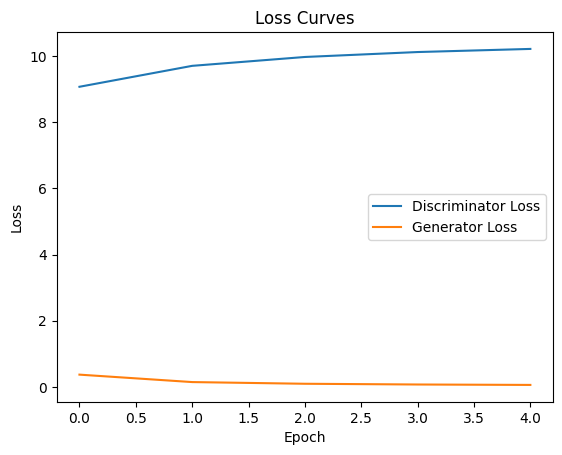

In [ ]:
# Plotting loss curves
def plot_loss_curves(d_loss_hist, g_loss_hist):
    plt.plot(d_loss_hist, label='Discriminator Loss')
    plt.plot(g_loss_hist, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

plot_loss_curves(d_loss_hist, g_loss_hist)

In [ ]:
# Calculate FID score
from scipy.linalg import sqrtm


def calculate_fid_score(real_images, generated_images):
    real_images_flat = real_images.reshape((real_images.shape[0], -1))
    generated_images_flat = generated_images.reshape((generated_images.shape[0], -1))
    
    mu_real, sigma_real = np.mean(real_images_flat, axis=0), np.cov(real_images_flat, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_images_flat, axis=0), np.cov(generated_images_flat, rowvar=False)
    
    ssdiff = np.sum((mu_real - mu_generated)**2.0)
    covmean = sqrtm(sigma_real.dot(sigma_generated))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    fid = ssdiff + np.trace(sigma_real + sigma_generated - 2.0 * covmean)
    return fid

# Generate images using the generator model
test_noise = np.random.normal(0, 1, (25, latent_dim))
generated_images = generator.predict(test_noise)

# Reshaping images for FID score calculation
real_images_fid = np.transpose(real_images, (0, 2, 3, 1))
generated_images_fid = np.transpose(generated_images, (0, 2, 3, 1))

# Calculating FID score
fid_score = calculate_fid_score(real_images_fid, generated_images_fid)
print("FID Score:", fid_score)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
FID Score: -9.893216058924181e+173
